<a href="https://colab.research.google.com/github/RayNCode/code_collab/blob/main/ROC_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is probably not the best/cleanest code for the ROCs, but I had very less time to optimise it further. Please feel free to change as you see fit.

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
sklearn.set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

**Data Preprocessing**

In [2]:
data_url = "https://raw.githubusercontent.com/RayNCode/code_collab/main/project-3-files"
learn_dataset = pd.read_csv(f"{data_url}/learn_dataset.csv").copy()
learn_dataset_Emp_contract = pd.read_csv(f"{data_url}/learn_dataset_Emp_contract.csv").copy()
learn_dataset_sport = pd.read_csv(f"{data_url}/learn_dataset_sport.csv").copy()
learn_dataset_job = pd.read_csv(f"{data_url}/learn_dataset_job.csv").copy()

code_work_description_map = pd.read_csv(f"{data_url}/code_work_description_map.csv").copy()
city_adm = pd.read_csv(f"{data_url}/city_adm.csv").copy()
code_Club = pd.read_csv(f"{data_url}/code_Club.csv").copy()
departments = pd.read_csv(f"{data_url}/departments.csv").copy()

test_dataset_job = pd.read_csv(f"{data_url}/test_dataset_job.csv").copy()
test_dataset = pd.read_csv(f"{data_url}/test_dataset.csv").copy()
test_dataset_Emp_contract = pd.read_csv(f"{data_url}/test_dataset_Emp_contract.csv").copy()
test_dataset_sport = pd.read_csv(f"{data_url}/test_dataset_sport.csv").copy()

In [3]:
def preprocess_data_base(learn_dataset_job, work_desc, learn_dataset, dept_code, emp_contract, learn_dataset_sport, code_club, departments):
    # Chargement et fusion des datasets de travail
    merged_df = pd.merge(learn_dataset_job, work_desc, left_on='work_description', right_on='N3', how='left')

    # Conversion des colonnes N2, N1 et N3 en chaînes de caractères
    merged_df['N2'] = merged_df['N2'].astype(str)
    merged_df['N1'] = merged_df['N1'].astype(str)
    merged_df['N3'] = merged_df['N3'].astype(str)

    # Remplir les valeurs manquantes
    merged_df['N2'].fillna(merged_df['N3'].str[:-2], inplace=True)
    merged_df['N1'].fillna(merged_df['N2'].str[:-1], inplace=True)

    # Fusion avec d'autres datasets
    data_2 = pd.merge(learn_dataset, merged_df, on="Id", how="left")
    df_1 = data_2.merge(dept_code, on='insee_code')
    df_2 = df_1.merge(emp_contract, on='Id', how='left')
    df_3 = df_2.merge(learn_dataset_sport, on='Id', how='left')
    df_4 = df_3.merge(code_Club, left_on='Club', right_on='Code', how='left')
    final_df = df_4.merge(departments, on='dep', how='left')

    # Conversion de type pour les colonnes 'Categorie' et 'REG'
    final_df['Categorie'] = final_df['Categorie'].astype(str).astype('object')
    final_df['REG'] = final_df['REG'].astype(str).astype('object')


    # Création et application d'une condition pour filtrer et imputer des valeurs
    condition = (final_df['ACTIVITY_TYPE'] != "TYPE1|1")
    final_df.loc[condition, ['EMOLUMENT', 'Working_hours']] = 0.0
    # Traitement des valeurs manquantes dans les colonnes catégorielles
    categorical_columns = final_df.select_dtypes(include=['object']).columns
    final_df[categorical_columns] = final_df[categorical_columns].fillna("None")


    return final_df

In [4]:
learn_dataset_base = preprocess_data_base(learn_dataset_job, code_work_description_map, learn_dataset, city_adm, learn_dataset_Emp_contract, learn_dataset_sport, code_Club, departments)
test_dataset_base = preprocess_data_base(test_dataset_job, code_work_description_map, test_dataset, city_adm, test_dataset_Emp_contract, test_dataset_sport, code_Club,departments)

In [5]:
def preprocess_learn_test(final_df): #ajouter l'ID quelque part
    # Séparer la variable cible si elle est présente
    if 'target' in final_df.columns:
        y = final_df['target'].copy()
        y = np.where(y == 'B', 1, 0)
        X = final_df.drop(['target'], axis='columns')
    else:
        X = final_df.copy()
        X_test_id = X['Id'].copy()

    # Suppression des colonnes non nécessaires
    X = X.drop(["Id", 'Nom de la commune', 'Nom fédération', 'Nom catégorie', 'Nom du département', 'Code'], axis="columns")


    # Imputation des valeurs manquantes - Ce n'est certainement pas la façon la plus efficiente de le faire. À voir si l'on change.
    imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=50, random_state=0)
    columns_to_impute = ['Working_hours', 'EMOLUMENT']
    X[columns_to_impute] = imputer.fit_transform(X[columns_to_impute])

    # On devrait essayer avec XGB et voir les performances également.
    # imputer = IterativeImputer(estimator=XGBRegressor(), max_iter=50, random_state=0)
    # columns_to_impute = ['Working_hours', 'EMOLUMENT']
    # X[columns_to_impute] = imputer.fit_transform(X[columns_to_impute])

    if 'target' in final_df.columns:
      return X, y
    else:
      return X, X_test_id

In [6]:
X, y = preprocess_learn_test(learn_dataset_base)
X_test, X_test_id = preprocess_learn_test(test_dataset_base)
print("Shape de X_train:", X.shape)
print("Shape de y_test:", y.shape)
print("Shape de X_test:", X_test.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Shape de X_train: (49993, 27)
Shape de y_test: (49993,)
Shape de X_test: (49992, 27)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

**ROC for Logistic Regression**

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


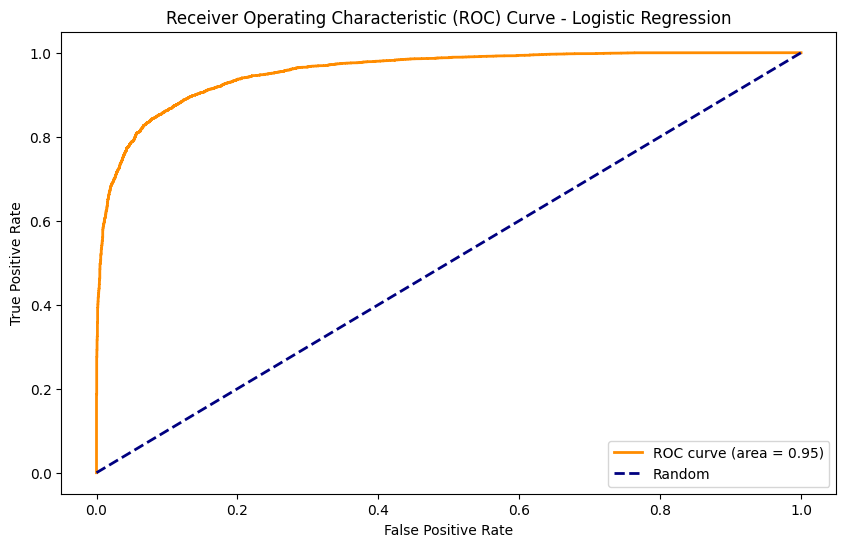

In [8]:
#Logistic Regression classifier with the best hyperparameters found in LogisticRegression.ipynb
logreg = LogisticRegression(
    solver='newton-cg',
    penalty='l2',
    multi_class='multinomial',
    max_iter=200,
    intercept_scaling=1,
    fit_intercept=False,
    dual=False,
    class_weight=None,
    C=1
)

preprocessing = make_column_transformer (
    (OneHotEncoder(handle_unknown='ignore'), ['insee_code',"is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex", "employer_category", "job_category", "Terms_of_emp",
                       "Eco_sect", "Job_dep", "WORK_CONDITION", "work_description","N3", "N2", "N1", "town_type", "dep", "Emp_contract", "Club", "Categorie", 'REG']),
    (OrdinalEncoder(), ["Highest_degree", "EMPLOYEE_COUNT"]),
    remainder='passthrough')
pipe_logreg = make_pipeline(preprocessing, logreg)

pipe_logreg.fit(X_train, y_train)

y_scores_test = pipe_logreg.decision_function(X_test)

#ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores_test)
roc_auc = auc(fpr, tpr)

#ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


**ROC for Random Forest**

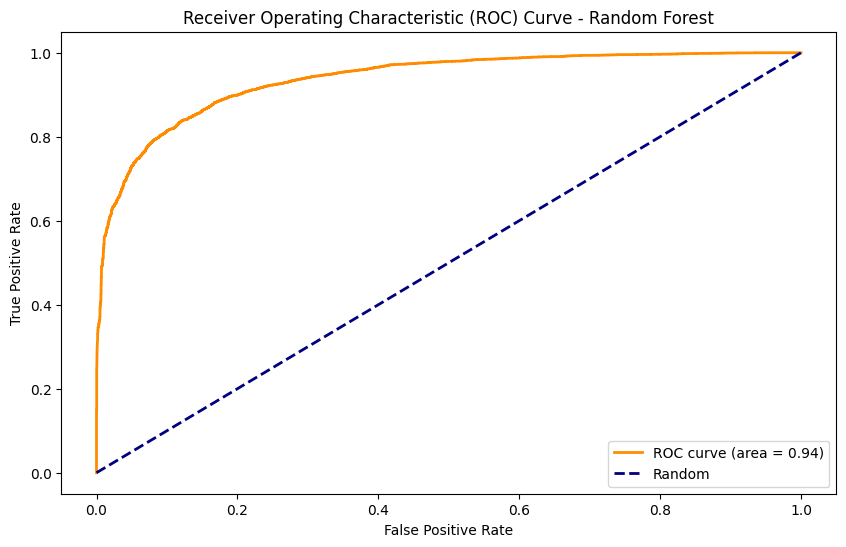

In [11]:
rf_classifier = RandomForestClassifier(
    oob_score=True,
    n_jobs=None,
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=2,
    min_impurity_decrease=0.0,
    max_leaf_nodes=None,
    max_features=None,
    max_depth=30,
    criterion='gini',
    bootstrap=True,
    )

preprocessing = make_column_transformer (
    (OneHotEncoder(handle_unknown='ignore'), ['insee_code',"is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex", "employer_category", "job_category", "Terms_of_emp",
                       "Eco_sect", "Job_dep", "WORK_CONDITION", "work_description","N3", "N2", "N1", "town_type", "dep", "Emp_contract", "Club", "Categorie", 'REG']),
    (OrdinalEncoder(), ["Highest_degree", "EMPLOYEE_COUNT"]),
    remainder='passthrough')
pipe_rf = make_pipeline(preprocessing, rf_classifier)

pipe_rf.fit(X_train, y_train)

y_scores_test = pipe_rf.predict_proba(X_test)[:, 1]

#ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

##prepropressing separately could not handle the floating variables for some reason, so i have to preprocess the dataset for every ROC. It is not the most optimal code so if you find anything better, please feel free to apply it.

**ROC for XGBoost**

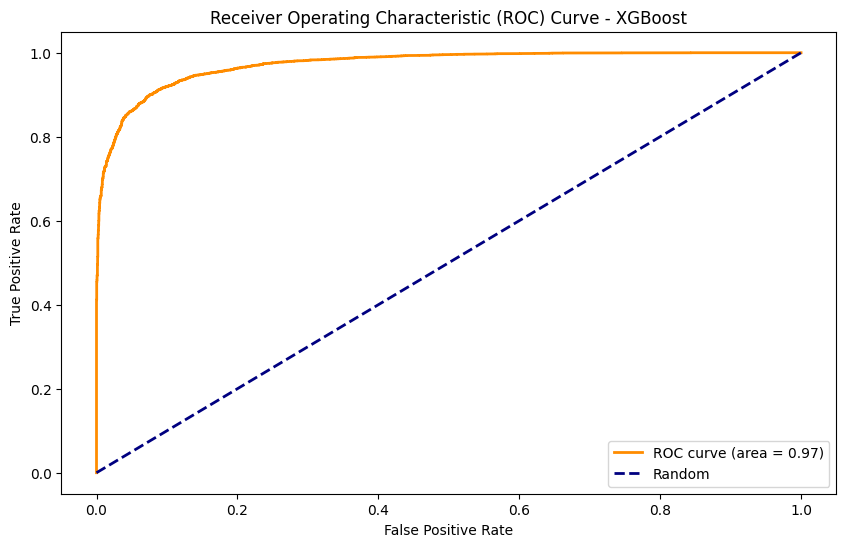

In [12]:
#XGBoost classifier with the best hyperparameters found in XGB_final_model.ipynb
xgb_classifier = XGBClassifier(
    subsample=0.9000000000000001,
    scale_pos_weight=0.8300000000000001,
    reg_lambda=0.08,
    reg_alpha=0.8,
    n_estimators=151,
    min_child_weight=3.279999999999994,
    max_depth=5,
    max_delta_step=1.54,
    learning_rate=0.76,
    gamma=0.9980000000000002,
    colsample_bytree=0.7100000000000001,
    colsample_bylevel=0.9400000000000002,
    random_state=42
)

preprocessing = make_column_transformer (
    (OneHotEncoder(handle_unknown='ignore'), ['insee_code',"is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex", "employer_category", "job_category", "Terms_of_emp",
                       "Eco_sect", "Job_dep", "WORK_CONDITION", "work_description","N3", "N2", "N1", "town_type", "dep", "Emp_contract", "Club", "Categorie", 'REG']),
    (OrdinalEncoder(), ["Highest_degree", "EMPLOYEE_COUNT"]),
    remainder='passthrough')
pipe_xgb = make_pipeline(preprocessing, xgb_classifier)

pipe_xgb.fit(X_train, y_train)

y_scores_test = pipe_xgb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()